In [65]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

In [66]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [97]:
# plot setup
plt.rcParams["figure.figsize"] = (6,4)

compatibility_order = ['novel','compatible','incompatible']

# Make dataframes

In [68]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping']

# which iteration name should we use?
# iteration_name = 'pilot_1'
iteration_name = 'pre_post_run_0'
iteration_names = [iteration_name]

In [69]:
# metadata
# TODO: check this works
query = coll.find({"$and":[
                        {'datatype':'metadata'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_meta = pd.DataFrame(query)
print(len(df_meta))

103


In [70]:
# metadata
# TODO: check this works
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_all = pd.DataFrame(query)
print(len(df_all))

27208


In [71]:
# zipping trials
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
                        ]})
df_zip = pd.DataFrame(query)
print(len(df_zip))

13735


In [72]:
# building trials
query = coll.find({"$and":[
                        {'trial_type':'block-construction'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_build = pd.DataFrame(query)
print(len(df_build))

1486


In [73]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'block_placement'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_block_placements = pd.DataFrame(query)
print(len(df_block_placements))

8381


In [74]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'reset'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_resets = pd.DataFrame(query)
print(len(df_resets))

2238


### Apply exclusion criteria

In [75]:
remove_tests = False

if remove_tests:
    df_zip = df_zip[~df_zip.workerID.isna()]
    df_build = df_build[~df_build.workerID.isna()]
    df_survey = df_survey[~df_survey.workerID.isna()]

In [76]:
# remove incomplete datasets
a = df_zip.groupby('gameID').apply(len) == 148
complete_zipping_set_gameIDs = list(a[a].index)
df_zip = df_zip[df_zip.gameID.isin(complete_zipping_set_gameIDs)]
df_build = df_build[df_build.gameID.isin(complete_zipping_set_gameIDs)]

In [77]:
df_zip = df_zip.merge(df_meta[['gameID','rotation_name']], on='gameID', how='left')

In [78]:
df_zip = df_zip[~pd.isna(df_zip.rotation_name)]

In [79]:
incomplete_zipping_set_gameIDs = list(a[~a].index)

In [80]:
print(str(len(incomplete_zipping_set_gameIDs)) + ' ppts removed for incomplete data')
print(str(len(complete_zipping_set_gameIDs)) + ' ppts left')

10 ppts removed for incomplete data
87 ppts left


In [81]:
# low accuracy
p = df_zip.groupby('gameID').response_correct.mean() > 0.5
ppt_greater_chance = list(p[p].index)
print(str(len(df_zip.groupby('gameID')) - len(ppt_greater_chance)) + ' ppts removed for low accuracy')

df_zip = df_zip[df_zip.gameID.isin(ppt_greater_chance)].reset_index()
print(str(len(ppt_greater_chance)) + ' ppts left')

3 ppts removed for low accuracy
75 ppts left


In [82]:
# TODO: flag button bashers
# key_presses is the number of times a key was pressed minus one.
df_zip.key_presses

0        0
1        1
2        0
3        0
4        0
        ..
11095    0
11096    0
11097    0
11098    0
11099    0
Name: key_presses, Length: 11100, dtype: int64

In [83]:
# flag fast RTs
df_zip.loc[:,'flagRT'] = False
df_zip.loc[(df_zip.rt > 5000), 'flagRT'] = True

In [84]:
print('{} trials flagged for slow RT'.format(df_zip['flagRT'].sum()))

62 trials flagged for slow RT


#### remove practice trials from df_zip

In [85]:
df_zip_practice = df_zip[df_zip.practice]
df_zip = df_zip[df_zip.practice == False]

## Add useful columns

In [86]:
# construct compatible variable
'''
A trial is compatible if the parts displayed are of the same orientation (wide/tall)
as the parts of that composite that were built.
If no parts of the composite were built, the trial is 'novel'. 
'''

df_zip.loc[:,'compatibility'] = 'novel'

df_zip.loc[((df_zip.compatible_condition == 'build_tall') & (df_zip.part_type == 'tall')) |
        ((df_zip.compatible_condition == 'build_wide') & (df_zip.part_type == 'wide')), 'compatibility'] = 'compatible'


df_zip.loc[((df_zip.compatible_condition == 'build_tall') & (df_zip.part_type == 'wide')) |
        ((df_zip.compatible_condition == 'build_wide') & (df_zip.part_type == 'tall')), 'compatibility'] = 'incompatible'

In [87]:
# is response_correct as we expect
df_zip.loc[:,'expected_response'] = df_zip.apply(lambda row: row.response_key_dict[row.validity],axis=1)
df_zip.loc[:,'recalculated_response_correct'] = df_zip.expected_response == df_zip.response
assert((df_zip.recalculated_response_correct == df_zip.response_correct).all())

# Test experiment design

In [88]:
df_zip[['compatibility','part_type','validity','part_a','part_b','composite_id']]

,compatibility,part_type,validity,part_a,part_b,composite_id
4,incompatible,tall,valid,tall_102,tall_122,talls_102_122
5,compatible,wide,valid,wide_025,wide_010,talls_102_122
6,novel,wide,valid,wide_011,wide_015,talls_111_127
8,compatible,tall,valid,tall_101,tall_114,talls_101_114
10,incompatible,wide,invalid,wide_019,wide_011,talls_101_114
...,...,...,...,...,...,...
11095,novel,wide,valid,wide_011,wide_015,talls_111_127
11096,compatible,tall,valid,tall_102,tall_122,talls_102_122
11097,incompatible,wide,valid,wide_025,wide_010,talls_102_122
11098,incompatible,tall,invalid,tall_101,tall_111,talls_101_114


We collected some extra participants. Here we drop the extras (taking the last ones). We should ensure that dropping these particular participants doesn't change our results before reporting them.

In [89]:
# check number of ppts in each condition
df_zip_ppts = df_zip.groupby('gameID').first()
df_zip_ppts.groupby('rotation_name').count()

,index,_id,trial_start_time,trial_finish_time,rt,stimulus,response,response_correct,stimURL,practice,...,composite_talls_name,actual_tall_parts,actual_wide_parts,trial_num,block,phase,flagRT,compatibility,expected_response,recalculated_response_correct
rotation_name,,,,,,,,,,,,,,,,,,,,,
p_1,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
p_2,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
q_1,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
q_2,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
r_1,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
r_2,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13


In [90]:
df_zip['gameID'].nunique()

75

In [91]:
df_ppts = df_zip.groupby('gameID').first().reset_index()
extras = list(\
df_ppts[df_ppts['rotation_name'] == 'r_1']['gameID'][12:].append(\
df_ppts[df_ppts['rotation_name'] == 'r_2']['gameID'][12:]))

df_zip = df_zip[~df_zip.gameID.isin(extras)]
# df_zip.groupby('gameID').first().groupby('rotation_name').count()
print('removed {} extra participants to preserve counterbalancing.'.format(len(extras)))

removed 3 extra participants to preserve counterbalancing.


#### Double checking built chunks

In [92]:
built_chunk_array = df_build.groupby('gameID').chunk_id.unique().apply(np.sort)
built_chunk_df = built_chunk_array.reset_index()
built_chunk_df = built_chunk_df.rename(columns={'chunk_id':'built_chunks'})

In [93]:
df_build = df_build.merge(built_chunk_df, how='left', on='gameID')
df_zip = df_zip.merge(built_chunk_df, how='left', on='gameID')

In [94]:
# df_meta_built = df_meta.groupby('gameID').building_chunks.first().apply(np.sort).reset_index()
# df_zip = df_zip.merge(df_meta_built, how='left', on='gameID')

In [95]:
df_zip.built_chunks

0        [tall_101, tall_114, wide_010, wide_025]
1        [tall_101, tall_114, wide_010, wide_025]
2        [tall_101, tall_114, wide_010, wide_025]
3        [tall_101, tall_114, wide_010, wide_025]
4        [tall_101, tall_114, wide_010, wide_025]
                           ...                   
10363    [tall_102, tall_122, wide_008, wide_019]
10364    [tall_102, tall_122, wide_008, wide_019]
10365    [tall_102, tall_122, wide_008, wide_019]
10366    [tall_102, tall_122, wide_008, wide_019]
10367    [tall_102, tall_122, wide_008, wide_019]
Name: built_chunks, Length: 10368, dtype: object

In [96]:
# Double check that compatible actually had those parts built 

a = df_zip[(df_zip.part_type=='tall') & 
       (df_zip.compatibility=='compatible')].actual_tall_parts.apply(np.sort)

b = df_zip[(df_zip.part_type=='tall') & 
       (df_zip.compatibility=='compatible')].built_chunks.apply(lambda part_list: np.sort([part for part in part_list if 'tall' in part]))

a.equals(b)

True

### Timing data

In [98]:
pre_start = df_zip[df_zip.trial_num == 0.0][['gameID','trial_start_time']]
pre_finish = df_zip[df_zip.trial_num == 71.0][['gameID','trial_finish_time']]
pre_start = pre_start.rename(columns = {'trial_start_time': 'pre_start_time'})
pre_finish = pre_finish.rename(columns = {'trial_finish_time':'pre_finish_time'})

pre_timing = pre_start.merge(pre_finish)
pre_timing['pre_duration'] = pre_timing['pre_finish_time'] - pre_timing['pre_start_time']
pre_timing['pre_duration_min'] = pre_timing['pre_duration'] / (1000 * 60)
pre_timing

,gameID,pre_start_time,pre_finish_time,pre_duration,pre_duration_min
0,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,1.657217e+12,1.657217e+12,392282.0,6.538033
1,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,1.657217e+12,1.657217e+12,391674.0,6.527900
2,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,1.657217e+12,1.657217e+12,371049.0,6.184150
3,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,1.657217e+12,1.657218e+12,396554.0,6.609233
4,7132-d5b59a6b-7b28-4aed-b5a1-be40d8bf4609,1.657225e+12,1.657225e+12,429140.0,7.152333
...,...,...,...,...,...
67,1730-53669bc0-b74e-40c6-b53b-ecfd3012915b,1.657248e+12,1.657248e+12,388638.0,6.477300
68,6415-d0ef7566-5045-4499-80ff-0812f9d98b3f,1.657248e+12,1.657249e+12,504719.0,8.411983
69,9919-0afd12f9-126c-4f2e-b2d0-c1c6ebb18a2b,1.657248e+12,1.657249e+12,360905.0,6.015083
70,7447-da0c7da5-12fd-4bf9-96b2-75a00cc5cd8b,1.657294e+12,1.657295e+12,455407.0,7.590117


In [99]:
post_start = df_zip[df_zip.trial_num == 72.0][['gameID','trial_start_time']]
post_finish = df_zip[df_zip.trial_num == 143.0][['gameID','trial_finish_time']]
post_start = post_start.rename(columns = {'trial_start_time': 'post_start_time'})
post_finish = post_finish.rename(columns = {'trial_finish_time':'post_finish_time'})

post_timing = post_start.merge(post_finish, on='gameID')
post_timing['post_duration'] = post_timing['post_finish_time'] - post_timing['post_start_time']
post_timing['post_duration_min'] = post_timing['post_duration'] / (1000 * 60)
post_timing

,gameID,post_start_time,post_finish_time,post_duration,post_duration_min
0,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,1.657217e+12,1.657218e+12,410613.0,6.843550
1,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,1.657218e+12,1.657218e+12,426243.0,7.104050
2,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,1.657218e+12,1.657218e+12,428918.0,7.148633
3,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,1.657219e+12,1.657219e+12,507647.0,8.460783
4,1302-913536d2-7068-4cc3-b278-aa4be9edc302,1.657226e+12,1.657226e+12,450642.0,7.510700
...,...,...,...,...,...
67,1730-53669bc0-b74e-40c6-b53b-ecfd3012915b,1.657249e+12,1.657249e+12,448552.0,7.475867
68,6415-d0ef7566-5045-4499-80ff-0812f9d98b3f,1.657249e+12,1.657250e+12,612294.0,10.204900
69,9919-0afd12f9-126c-4f2e-b2d0-c1c6ebb18a2b,1.657250e+12,1.657250e+12,473265.0,7.887750
70,7447-da0c7da5-12fd-4bf9-96b2-75a00cc5cd8b,1.657295e+12,1.657296e+12,425090.0,7.084833


In [100]:
df_build['trial_num'] = df_build.trial_index - 85
df_build['trial_num']

build_start = df_build[df_build.trial_num == 0][['gameID','trial_start_time']]
build_start = build_start.rename(columns = {'trial_start_time': 'build_start_time'})

build_finish = df_build[df_build.trial_num == 15][['gameID','timeAbsolute']]
build_finish = build_finish.rename(columns= {'timeAbsolute':'build_finish_time'})
build_timing = build_start.merge(build_finish, on='gameID')
build_timing['build_duration'] = build_timing['build_finish_time'] - build_timing['build_start_time']
build_timing['build_duration_min'] = build_timing['build_duration'] / (1000 * 60)
build_timing

,gameID,build_start_time,build_finish_time,build_duration,build_duration_min
0,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,1.657217e+12,1.657217e+12,169339.0,2.822317
1,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,1.657217e+12,1.657217e+12,228931.0,3.815517
2,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,1.657217e+12,1.657217e+12,144606.0,2.410100
3,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,1.657217e+12,1.657218e+12,744013.0,12.400217
4,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,1.657218e+12,1.657219e+12,999213.0,16.653550
...,...,...,...,...,...
82,8604-17243e13-050c-4c1a-b0b6-55c31b777cfa,1.657250e+12,1.657250e+12,263382.0,4.389700
83,7197-823dff6e-3420-4b62-8128-e1034077ad07,1.657255e+12,1.657255e+12,131329.0,2.188817
84,7447-da0c7da5-12fd-4bf9-96b2-75a00cc5cd8b,1.657295e+12,1.657295e+12,245211.0,4.086850
85,7428-1efc75e2-2045-46b6-b8a9-a38ffc9d7c63,1.657297e+12,1.657297e+12,310129.0,5.168817


In [101]:
# # this doesn't give an accurate assessment of instruction time
# # time_elapsed is the total jspsych time
# # max() gives us the time until the end of the latest instruction

# instruction_timing = df_all[df_all.trial_type == 'instructions'].groupby('gameID')['time_elapsed'].max().reset_index()
# instruction_timing = instruction_timing.rename(columns={'time_elapsed': 'instruction_duration'})
# instruction_timing['instruction_duration_min'] = instruction_timing['instruction_duration'] / (1000*60)

#### Trying to extract time in instructions. Not saved in experiment so using timestamps. Was taking too long so moving on.

In [102]:
# from bson import ObjectId
# import datetime as dt

# df_meta['time_stamp'] = df_meta._id.apply(lambda mongoID: ObjectId(mongoID).generation_time)

# epoch = dt.datetime(1970, 1, 1)

# timings['time_stamp'].apply(lambda d: (d - epoch).total_seconds())

# experiment_start = df_meta[['gameID','time_stamp']]

In [103]:
timings = pre_timing.merge(post_timing, on='gameID')\
                    .merge(build_timing, on='gameID')\
#                     .merge(experiment_start, how='left', on='gameID')

timings['total_duration'] = timings.post_finish_time - timings.pre_start_time
timings['total_duration_min'] = timings['total_duration'] / (1000*60)

mean pre duration:  6.788604861111111


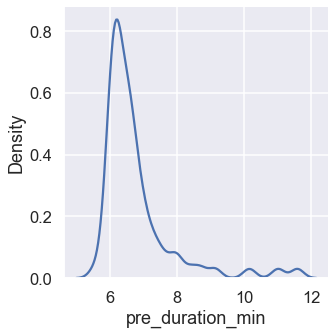

In [104]:
sns.displot(timings, x="pre_duration_min", kind="kde", bw_adjust=.4)
print('mean pre duration: ', timings.pre_duration_min.mean())

mean post duration:  8.078104861111113


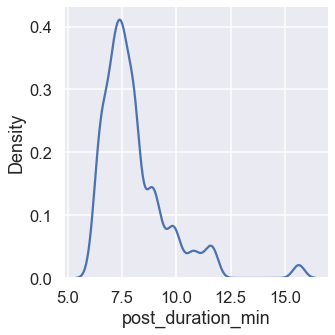

In [105]:
sns.displot(timings, x="post_duration_min", kind="kde", bw_adjust=.4)
print('mean post duration: ', timings.post_duration_min.mean())

mean building duration:  7.470501620370371


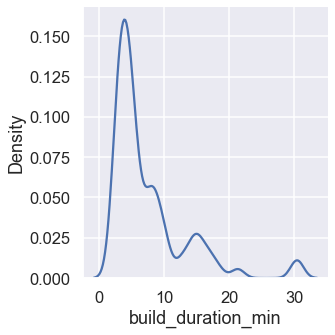

In [106]:
sns.displot(timings, x="build_duration_min", kind="kde", bw_adjust=.4)
print('mean building duration: ', timings.build_duration_min.mean())

mean total duration:  24.268188657407407


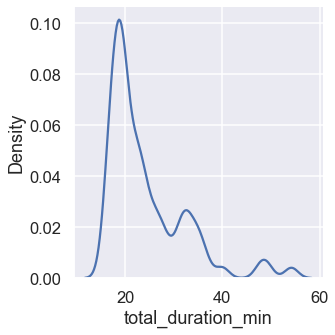

In [107]:
sns.displot(timings, x="total_duration_min", kind="kde", bw_adjust=.4)
print('mean total duration: ', timings.total_duration_min.mean())

#### export for stats

In [108]:
filename = '../results/zipping/csv/df_zip_{}.csv'.format(iteration_name)
df_zip.to_csv(filename)
print(filename)

../results/zipping/csv/df_zip_pre_post_run_0.csv


# Analysis 

### Analysis setup

In [109]:
block_order = ['pre_0', 'pre_1', 'post_0', 'post_1']
phase_order = ['pre_zipping_trials', 'post_zipping_trials']

No handles with labels found to put in legend.


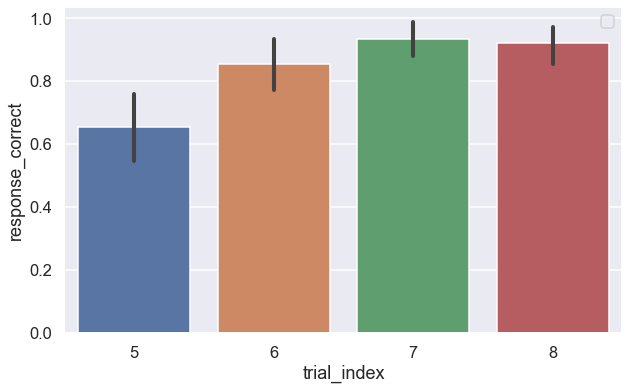

In [110]:
# Do people understand practice trials?

fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip_practice, 
              y= "response_correct", 
              x= "trial_index",
              )

plt.legend(bbox_to_anchor=(1,1))

In general yes. Lots of mistakes in the first trial. People reported being thrown off by the mask. But accuracy is v high by the end.

In [111]:
df_zip = df_zip[~df_zip.practice].reset_index(drop=True)

### plot setup

In [112]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

## zipping trials- group level performance

<AxesSubplot:xlabel='gameID', ylabel='response_correct'>

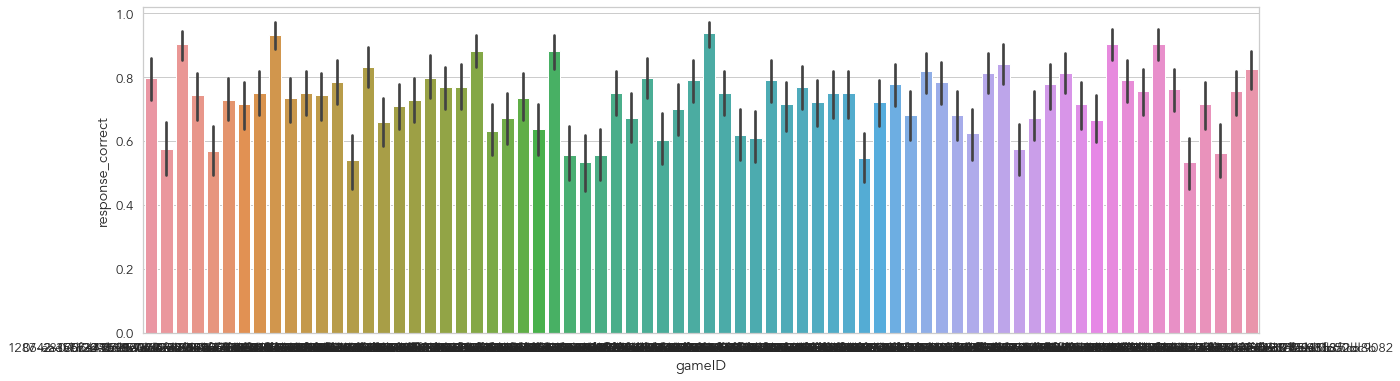

In [239]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data=df_zip, 
              y= "response_correct", 
              x= "gameID",
              )

<AxesSubplot:xlabel='gameID', ylabel='rt'>

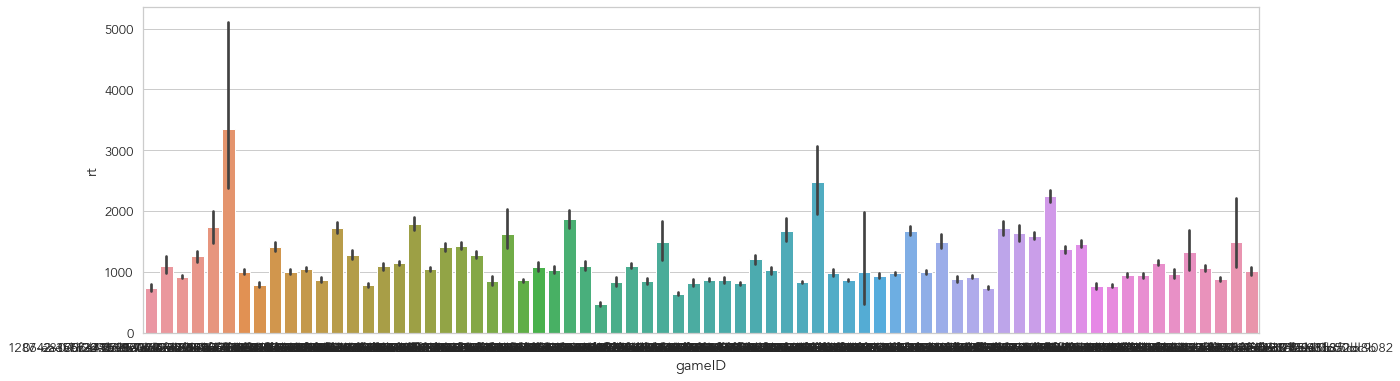

In [240]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data=df_zip, 
              y= "rt", 
              x= "gameID",
              )

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/U

Text(0.5, 0, 'log(RT)')

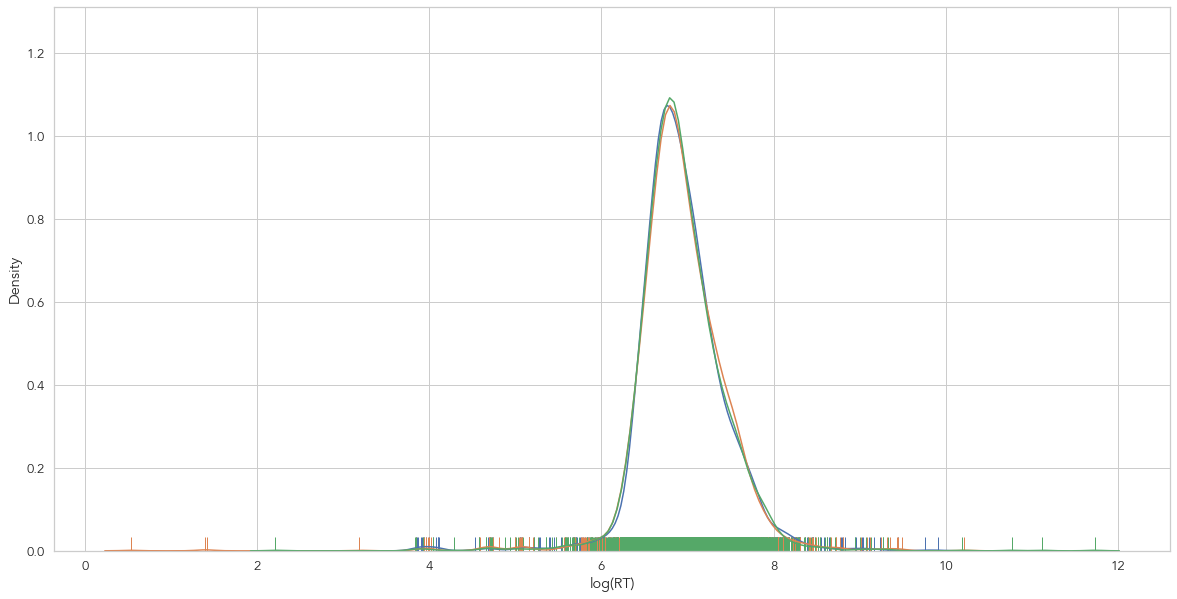

In [113]:
plt.figure(figsize=(20,10))
sns.distplot(np.log(df_zip[df_zip.compatibility == 'compatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'incompatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'novel'].rt), rug=True, hist=False)
plt.xlabel('log(RT)')

In [114]:
df_zip.phase

0         pre_zipping_trials
1         pre_zipping_trials
2         pre_zipping_trials
3         pre_zipping_trials
4         pre_zipping_trials
                ...         
10363    post_zipping_trials
10364    post_zipping_trials
10365    post_zipping_trials
10366    post_zipping_trials
10367    post_zipping_trials
Name: phase, Length: 10368, dtype: object

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/U

Text(0.5, 0, 'log(RT)')

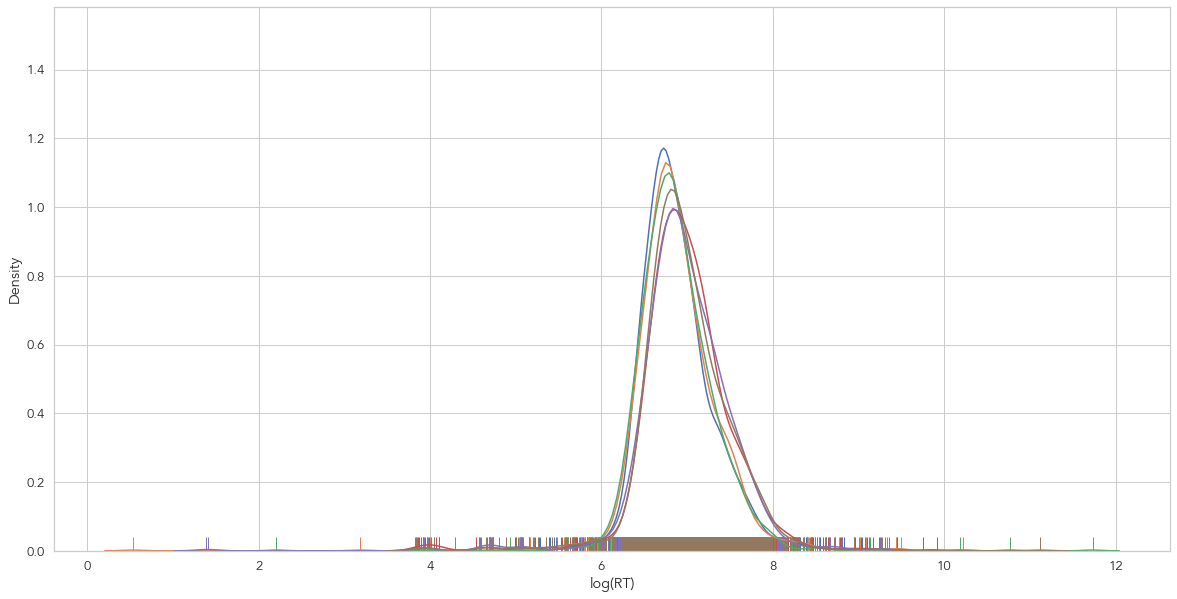

In [115]:
plt.figure(figsize=(20,10))
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'compatible') & (df_zip.phase == 'pre_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'incompatible')& (df_zip.phase == 'pre_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'novel') & (df_zip.phase == 'pre_zipping_trials')].rt), rug=True, hist=False)

sns.distplot(np.log(df_zip[(df_zip.compatibility == 'compatible') & (df_zip.phase == 'post_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'incompatible')& (df_zip.phase == 'post_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'novel') & (df_zip.phase == 'post_zipping_trials')].rt), rug=True, hist=False)
plt.xlabel('log(RT)')

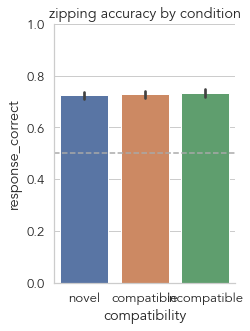

In [116]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="compatibility",
                order = compatibility_order,
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.title('zipping accuracy by condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

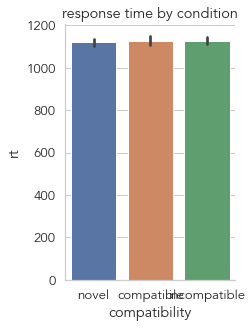

In [117]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt",
                x="compatibility",
                order = compatibility_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by condition')
plt.show()

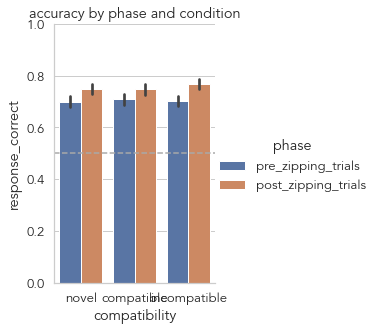

In [241]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                hue="phase",
                x="compatibility",
                order = compatibility_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by phase and condition')
plt.show()

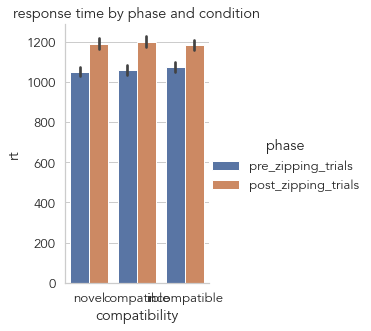

In [242]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                hue="phase",
                x="compatibility",
                order = compatibility_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by phase and condition')
plt.show()

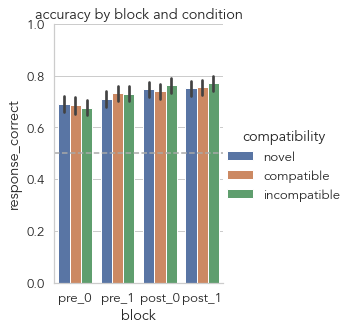

In [137]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
                hue_order = compatibility_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by block and condition')
plt.show()

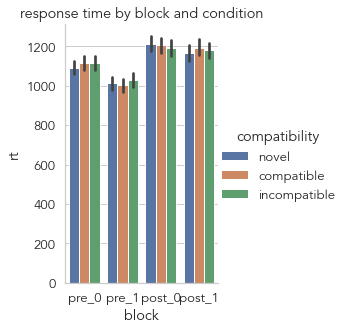

In [138]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
                hue_order = compatibility_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by block and condition')
plt.show()

### Investigating an interaction between phase and condition

#### RT

Text(0.5, 1.0, 'response time by phase and condition')

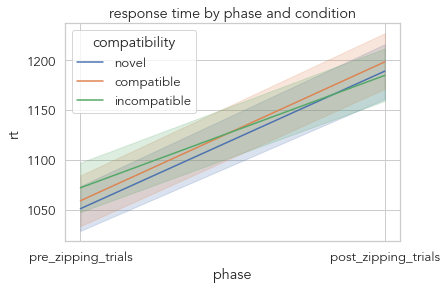

In [139]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
             hue_order = compatibility_order,
            )
plt.title('response time by phase and condition')

Text(0.5, 1.0, 'response time by phase and condition')

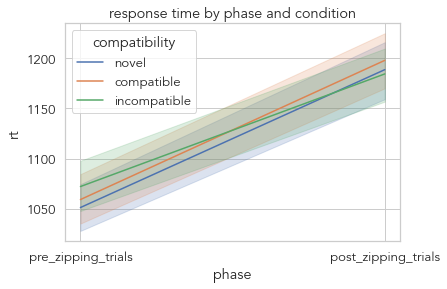

In [140]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
             hue_order = compatibility_order,
            )
plt.title('response time by phase and condition')

Text(0.5, 1.0, 'response time by block and condition')

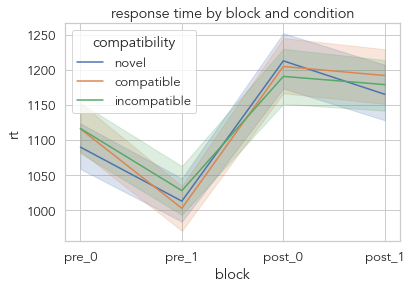

In [141]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
                hue_order = compatibility_order,
            )
plt.title('response time by block and condition')

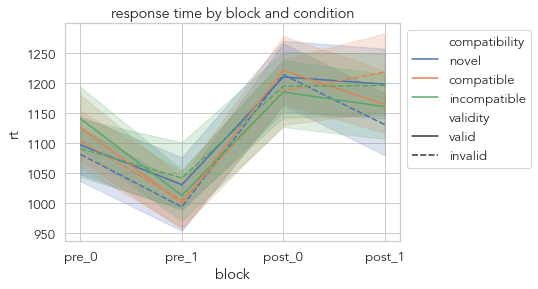

In [142]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                style="validity",
                hue="compatibility",
                hue_order = compatibility_order,
            )
plt.title('response time by block and condition')
plt.legend(bbox_to_anchor=(1,1))

The expectation was that rt would drop for compatible and (maybe) rise for incompatible.
But RT is higher for all conditions after the building task.
And even after practice they don't get as fast as they used to be.
What's going on?

What's the simplest explanation of this?
People get tired? But then they would continue to get worse.

People are taking longer to parse the objects?
But if so, they're doing it indiscriminantly- there is no difference between novel and built.

#### accuracy

Text(0.5, 1.0, 'accuracy time by phase and condition')

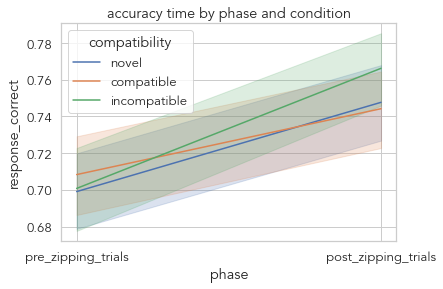

In [143]:
sns.lineplot(data = df_zip,
                y="response_correct", 
                x="phase",
                hue="compatibility",
                 hue_order = compatibility_order,
            )
plt.title('accuracy time by phase and condition')

Text(0.5, 1.0, 'accuracy time by block and condition')

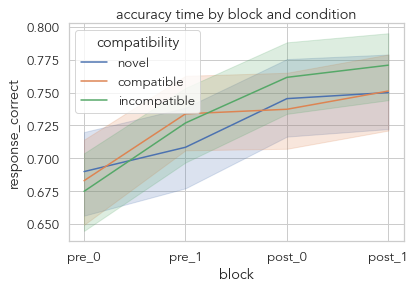

In [144]:
sns.lineplot(data = df_zip,
                y="response_correct", 
                x="block",
                hue="compatibility",
                hue_order = compatibility_order,
            )
plt.title('accuracy time by block and condition')

But they're more accurate.

### Stimuli

Does the same pattern hold across different stimulus 'rotations'?

There are three stimuli that we rotate into different positions.
Each of the three stims can be novel. And the other two stims can have wide parts built or tall parts built.


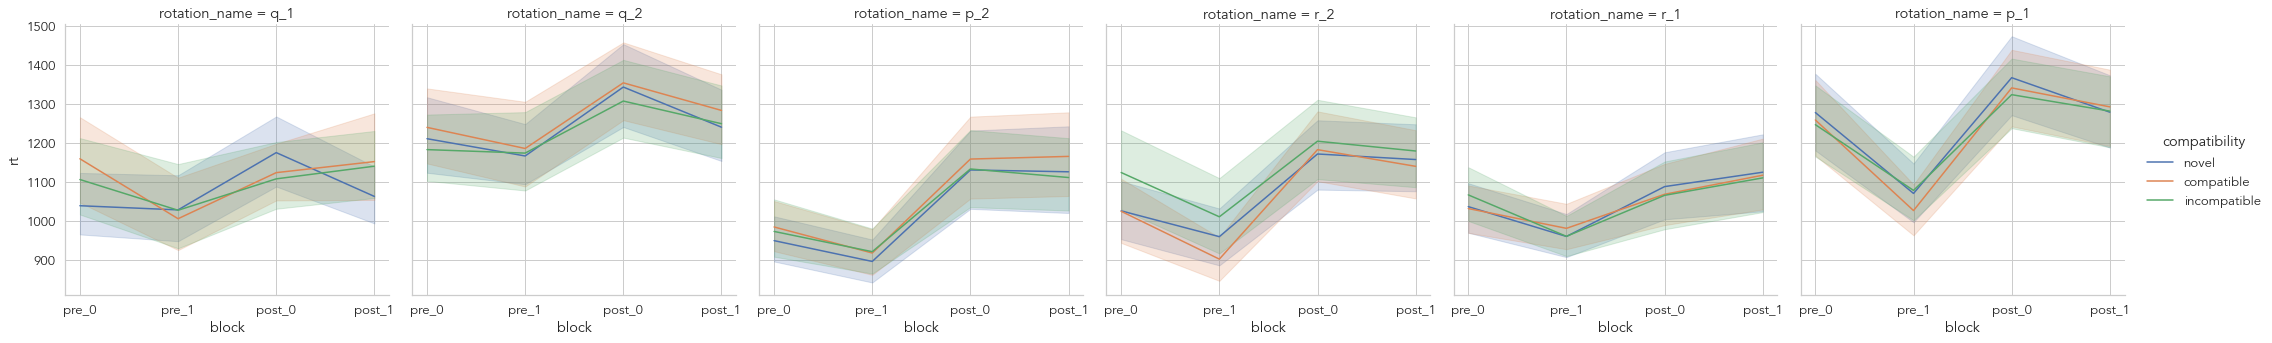

In [145]:
# response time by block and condition, separated by rotation 

f = sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="rt", 
                x="block",
                hue="compatibility",
                hue_order = compatibility_order,
                kind='line')

Text(0.5, 1.0, 'accuracy by block and condition')

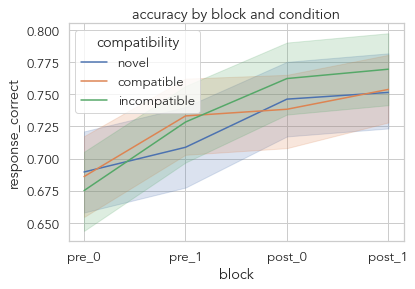

In [146]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
                 hue_order = compatibility_order,
            )

plt.title('accuracy by block and condition')

Text(0.5, 1.0, 'accuracy by block and condition, separated by rotation')

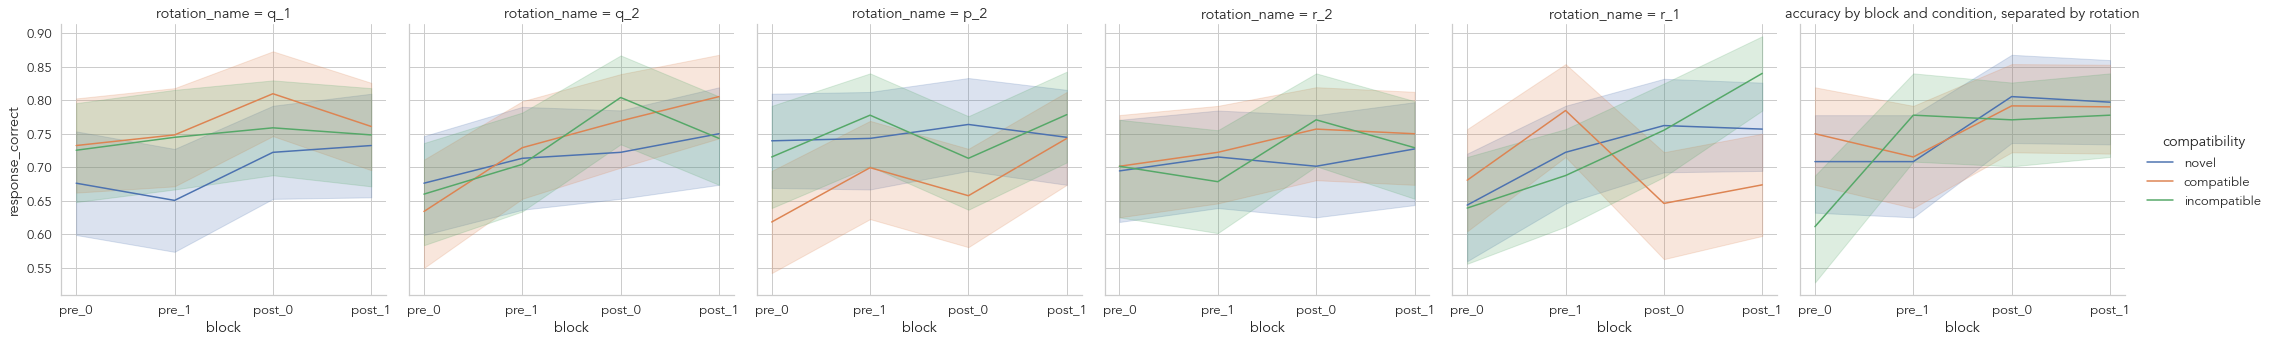

In [147]:
sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="response_correct", 
                x="block",
                hue="compatibility",
                hue_order = compatibility_order,
                kind='line')

plt.title('accuracy by block and condition, separated by rotation')

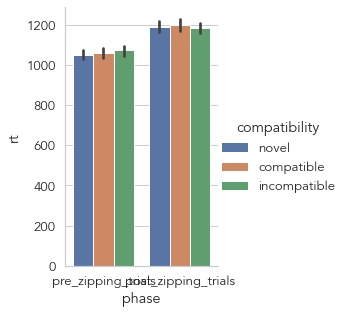

In [148]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
                hue_order = compatibility_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()


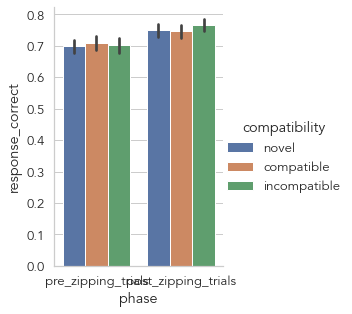

In [149]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="phase",
                hue="compatibility",
                hue_order = compatibility_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

## zipping trials- participant level performance

Variation in participant performance

In [150]:
df_zip_ppt_mean = df_zip.groupby(['gameID']).mean().reset_index().merge(df_zip[['gameID','rotation_name']].groupby('gameID').last().reset_index(), 
                                                                        how='left',
                                                                        on='gameID')

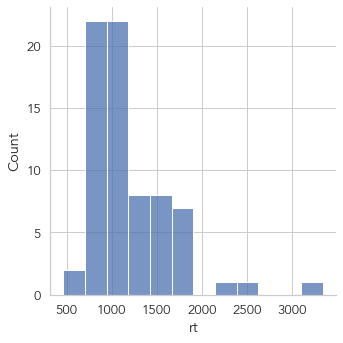

In [151]:
sns.displot(df_zip_ppt_mean, x='rt', kind='hist')

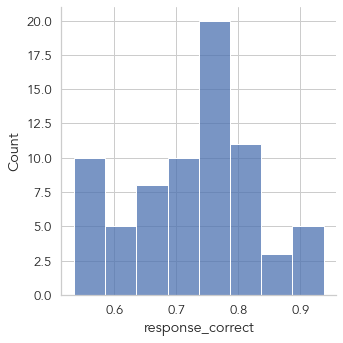

In [152]:
sns.displot(df_zip_ppt_mean, x='response_correct', kind='hist')

In [153]:
# anything that effects ppt level performance?

In [154]:
rotations = df_meta[['rotation', 'rotation_name']].groupby('rotation_name').first()
rotations = rotations.to_dict()

In [155]:
import requests

In [156]:
def show_stim(url, ax):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
#     plt.figure(figsize=(2,1))
    ax.imshow(img)
    ax.axis('off')
    
def display_rotation(rotation_name, 
                     url_stem = 'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_{}.png'):
    print(rotation_name)
    print('build_wide      build_tall      novel')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['build_wide']), ax1)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['build_tall']), ax2)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['novel']), ax3)


def show_part(part_id,
              verbose = False,
              url_stem = "https://lax-tower-4-block-unique-silhouettes-png.s3.amazonaws.com/tower_4_block_unique_silhouette_{}.png"):
    
    if verbose:
        print(part_id)
    response = requests.get(url_stem.format(part_id.split('_')[1]))
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(3,2))
    plt.imshow(img)
    plt.axis('off')
    
def show_part_subplot(part_id,
                      ax,
              url_stem = "https://lax-tower-4-block-unique-silhouettes-png.s3.amazonaws.com/tower_4_block_unique_silhouette_{}.png"):
    
    response = requests.get(url_stem.format(part_id.split('_')[1]))
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(part_id)


In [157]:
rotation_order = np.sort(df_zip_ppt_mean.rotation_name.unique())

<AxesSubplot:xlabel='rotation_name', ylabel='rt'>

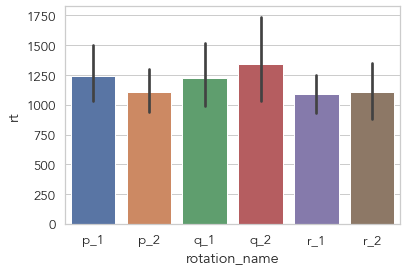

In [158]:
sns.barplot(data=df_zip_ppt_mean,
            y='rt',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='rt'>

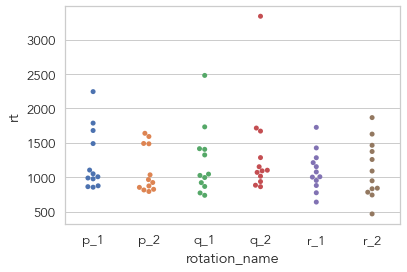

In [159]:
sns.swarmplot(data=df_zip_ppt_mean,
            y='rt',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='response_correct'>

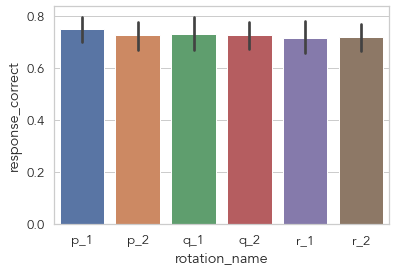

In [160]:
sns.barplot(data=df_zip_ppt_mean,
            y='response_correct',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='response_correct'>

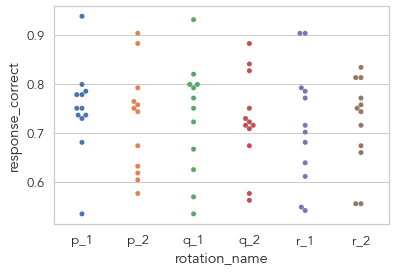

In [161]:
sns.swarmplot(data=df_zip_ppt_mean,
            y='response_correct',
            x='rotation_name',
            order = rotation_order)

p_1
build_wide      build_tall      novel


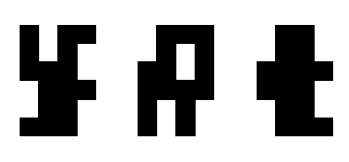

In [162]:
display_rotation(rotation_order[0])

p_2
build_wide      build_tall      novel


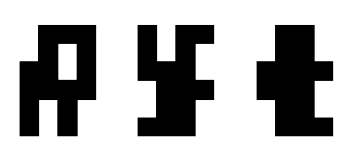

In [163]:
display_rotation(rotation_order[1])

q_1
build_wide      build_tall      novel


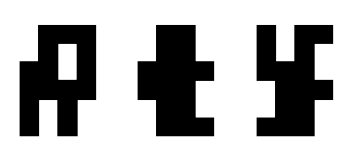

In [164]:
display_rotation(rotation_order[2])

q_2
build_wide      build_tall      novel


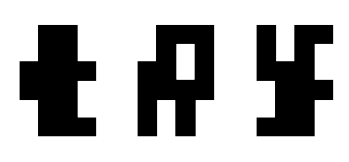

In [165]:
display_rotation(rotation_order[3])

r_1
build_wide      build_tall      novel


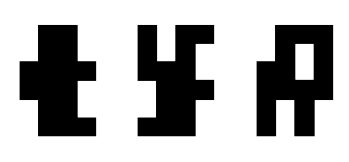

In [166]:
display_rotation(rotation_order[4])

r_2
build_wide      build_tall      novel


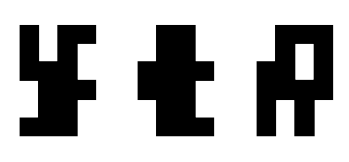

In [167]:
display_rotation(rotation_order[5])

<AxesSubplot:xlabel='rt', ylabel='response_correct'>

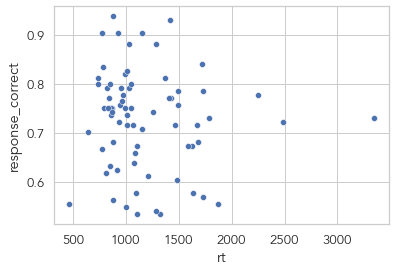

In [168]:
# looking for speed accuracy trade-off

sns.scatterplot(data = df_zip_ppt_mean,
                x = 'rt',
                y = 'response_correct')

In [169]:
def phase_diff(df):
    '''
    Returns difference between rare and phase conditions for response correct and rt
    '''
    diffs = df[df.phase=='post_zipping_trials'][['response_correct','rt']].iloc[0] - df[df.phase=='pre_zipping_trials'][['response_correct','rt']].iloc[0] 
    
    
    diffs = diffs.rename({'response_correct':'diff_response_correct',
                                'rt':'diff_rt'})
    
    return diffs

In [170]:
df_zip_phase_mean = df_zip.groupby(['gameID','phase']).mean().reset_index()

In [171]:
# start with means
ppt_phase_diffs = df_zip_phase_mean.groupby('gameID')[['response_correct','rt','phase']]

# find differences between phase conditions
ppt_phase_diffs = ppt_phase_diffs.apply(phase_diff)

# merge in useful data from original dataframe
ppt_phase_diffs = ppt_phase_diffs.merge(df_zip.groupby('gameID').first()\
                    [['iterationName','composite_duration','rotation_name']], how='left', on='gameID')

# merge mean columns from original mean dataframe
ppt_phase_diffs = ppt_phase_diffs.merge(df_zip_phase_mean.groupby('gameID').first()\
                    [['rt','response_correct']], how='left', on='gameID')

# and rename mean columns
ppt_phase_diffs = ppt_phase_diffs.rename(columns=
                 {'response_correct':'mean_response_correct',
                                'rt':'mean_rt'})

ppt_phase_diffs

,diff_response_correct,diff_rt,iterationName,composite_duration,rotation_name,mean_rt,mean_response_correct
gameID,,,,,,,
0006-45bd8004-9f80-4c7f-aba2-610e170754cb,0.097222,99.958333,pre_post_run_0,600,r_2,1307.666667,0.791667
0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,0.166667,66.797222,pre_post_run_0,600,p_1,1009.436111,0.861111
0462-c64aea8d-3207-416f-b75e-9ad1e371c8c1,0.027778,46.650000,pre_post_run_0,600,r_2,488.851389,0.569444
0583-6b2d7882-0eab-45f9-a075-192f478b0256,0.097222,-79.769444,pre_post_run_0,600,p_2,774.104167,0.666667
0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,0.097222,-144.652778,pre_post_run_0,600,q_2,1020.075000,0.625000
...,...,...,...,...,...,...,...
8529-deb9399f-3677-4c25-b7c7-6e74696b2e48,0.097222,179.862500,pre_post_run_0,600,p_2,1682.212500,0.722222
9120-19f24161-e3be-4c42-8796-3429380b5dd2,0.166667,-60.590278,pre_post_run_0,600,p_1,958.012500,0.833333
9663-a33e352b-c21f-46a2-b422-70bce3486bc9,0.194444,-51.000000,pre_post_run_0,600,q_2,910.930556,0.819444


### Look at within-participant, between phase differences in RT and accuracy

<AxesSubplot:ylabel='diff_rt'>

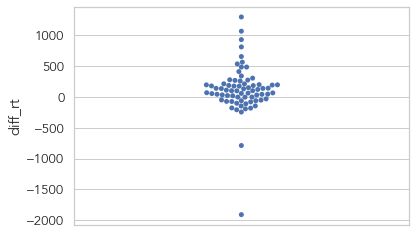

In [172]:
sns.swarmplot(data = ppt_phase_diffs,
              y = 'diff_rt')

<AxesSubplot:ylabel='diff_response_correct'>

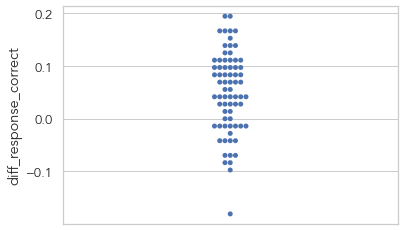

In [173]:
sns.swarmplot(data = ppt_phase_diffs,
              y = 'diff_response_correct')

(-500.0, 1500.0)

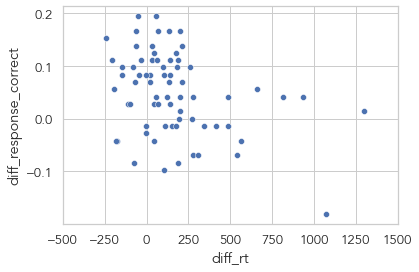

In [174]:
# looking for speed accuracy trade-off

sns.scatterplot(data = ppt_phase_diffs,
                x = 'diff_rt',
              y = 'diff_response_correct')

plt.xlim(-500,1500)

### Look at within-participant, within-condition, between phase differences in RT and accuracy

(i.e. does a person get more accurate or faster for one condition in particular?)

In [175]:
df_zip_phase_compatibility_mean = df_zip.groupby(['gameID','phase','compatibility']).mean().reset_index()

In [176]:
# start with means
ppt_phase_compatibility_diffs = df_zip_phase_compatibility_mean.groupby(['gameID','compatibility'])[['response_correct','rt','phase']]

# find differences between phase conditions
ppt_phase_compatibility_diffs = ppt_phase_compatibility_diffs.apply(phase_diff).reset_index()

# merge in useful data from original dataframe
ppt_phase_compatibility_diffs = ppt_phase_compatibility_diffs.merge(df_zip.groupby('gameID').first()\
                    [['iterationName','rotation_name']], how='left', on='gameID')

# merge mean columns from original mean dataframe
ppt_phase_compatibility_diffs = ppt_phase_compatibility_diffs.merge(df_zip_phase_compatibility_mean.groupby('gameID').first()\
                    [['rt','response_correct']], how='left', on='gameID')

# and rename mean columns
ppt_phase_compatibility_diffs = ppt_phase_compatibility_diffs.rename(columns=
                 {'response_correct':'mean_response_correct',
                                'rt':'mean_rt'})

ppt_phase_compatibility_diffs


,gameID,compatibility,diff_response_correct,diff_rt,iterationName,rotation_name,mean_rt,mean_response_correct
0,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,compatible,0.333333,180.541667,pre_post_run_0,r_2,1185.875000,0.916667
1,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,incompatible,-0.166667,-84.791667,pre_post_run_0,r_2,1185.875000,0.916667
2,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,novel,0.125000,204.125000,pre_post_run_0,r_2,1185.875000,0.916667
3,0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,compatible,0.125000,137.183333,pre_post_run_0,p_1,1056.308333,0.875000
4,0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,incompatible,0.208333,-0.583333,pre_post_run_0,p_1,1056.308333,0.875000
...,...,...,...,...,...,...,...,...
211,9919-0afd12f9-126c-4f2e-b2d0-c1c6ebb18a2b,incompatible,-0.125000,183.583333,pre_post_run_0,q_2,1012.745833,0.583333
212,9919-0afd12f9-126c-4f2e-b2d0-c1c6ebb18a2b,novel,0.000000,139.050000,pre_post_run_0,q_2,1012.745833,0.583333
213,9984-ef648e44-23bb-4658-96f4-7be5c145c151,compatible,-0.083333,173.345833,pre_post_run_0,p_2,979.200000,0.625000
214,9984-ef648e44-23bb-4658-96f4-7be5c145c151,incompatible,0.083333,57.212500,pre_post_run_0,p_2,979.200000,0.625000


/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='compatibility', ylabel='diff_rt'>

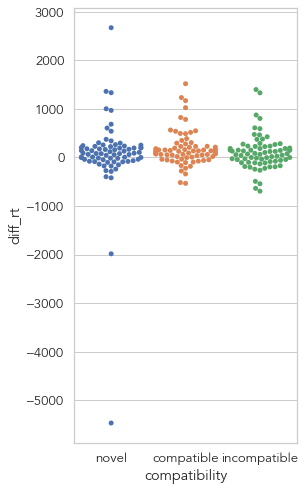

In [177]:
plt.figure(figsize = (4,8))

sns.swarmplot(data = ppt_phase_compatibility_diffs,
              y = 'diff_rt',
              x = 'compatibility',
              order = compatibility_order,)

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='compatibility', ylabel='diff_response_correct'>

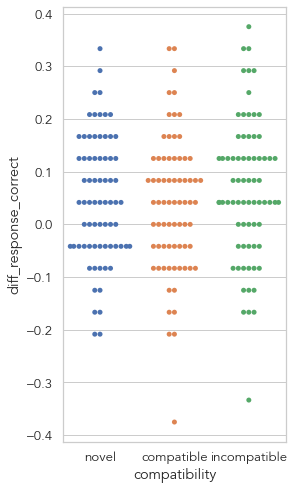

In [228]:
plt.figure(figsize = (4,8))

sns.swarmplot(data = ppt_phase_compatibility_diffs,
              y = 'diff_response_correct',
              x = 'compatibility',
              order = compatibility_order,)

AttributeError: 'PathCollection' object has no property 'order'

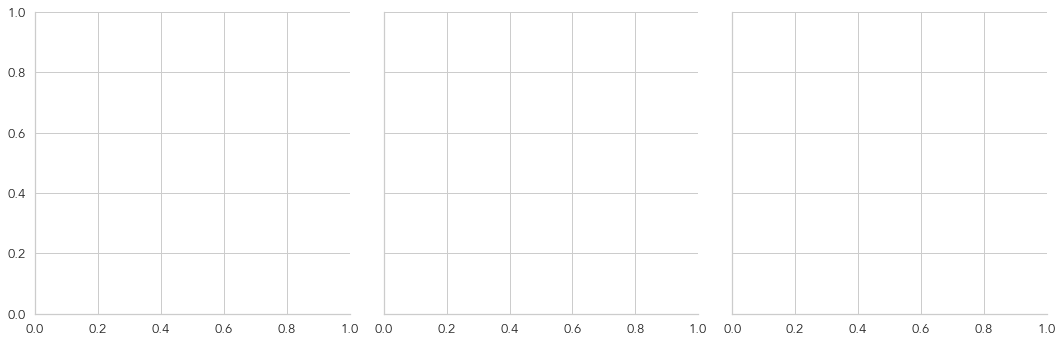

In [229]:
# looking for speed accuracy trade-off

sns.relplot(data = ppt_phase_compatibility_diffs,
            col='compatibility',
            hue='compatibility',
            x = 'diff_rt',
            order = compatibility_order,
            y = 'diff_response_correct')

plt.xlim(-500,1500)

<AxesSubplot:xlabel='compatibility', ylabel='diff_response_correct'>

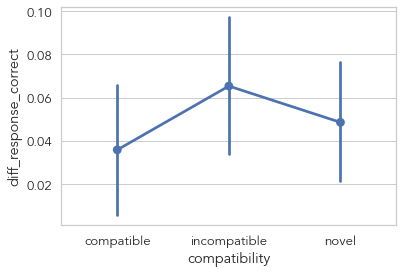

In [180]:
sns.pointplot(data = ppt_phase_compatibility_diffs,
              y = 'diff_response_correct',
              x = 'compatibility')

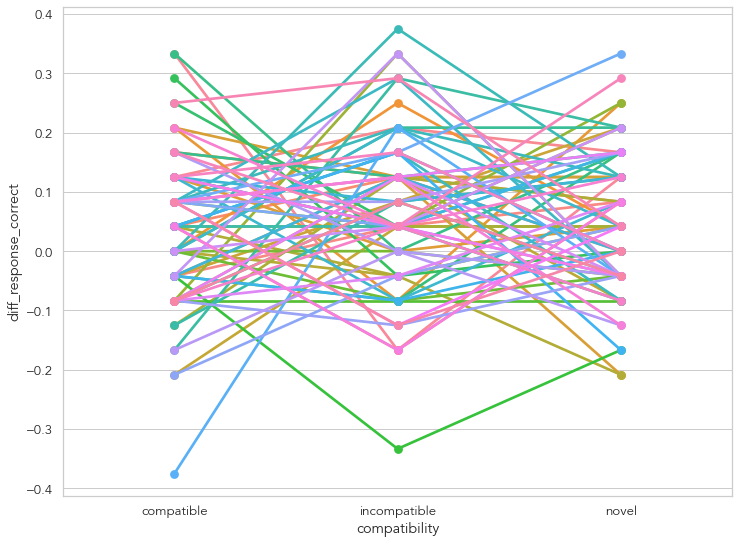

In [181]:
plt.figure(figsize=(12,9))

sns.pointplot(data = ppt_phase_compatibility_diffs,
              y = 'diff_response_correct',
              x = 'compatibility',
              hue = 'gameID')

plt.legend([],[], frameon=False)

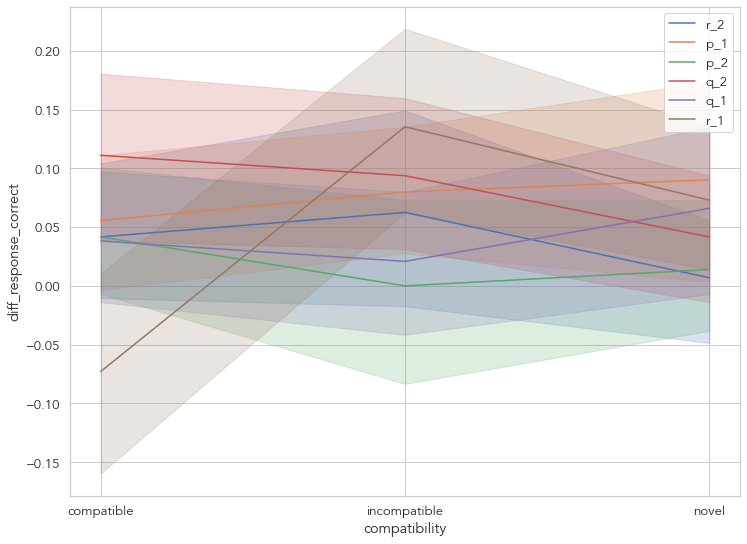

In [182]:
plt.figure(figsize=(12,9))

sns.lineplot(data = ppt_phase_compatibility_diffs,
              y = 'diff_response_correct',
              x = 'compatibility',
              hue = 'rotation_name')

plt.legend(bbox_to_anchor = (1,1))

### Part type

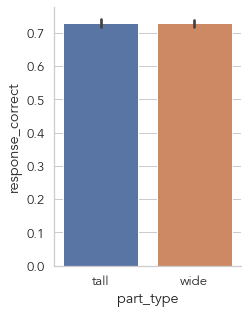

In [230]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="part_type",
#                 hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

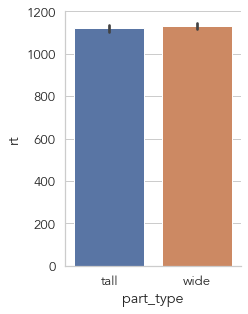

In [233]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="part_type",
#                 hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

### Stimulus

In [247]:
composite_order = np.sort(df_zip.composite_id.unique())

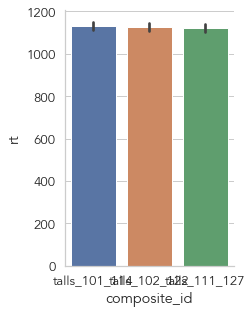

In [249]:
# Is one of the stims easier across the board?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="composite_id",
                order=composite_order,
#                 hue="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

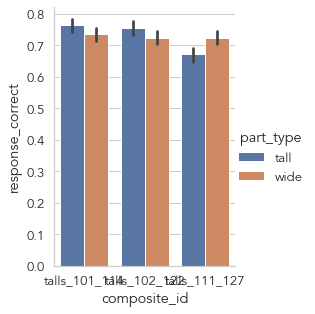

In [250]:
# Are any of the stims easier in one direction?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="composite_id",
                order=composite_order,
                hue="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

## d'

In [186]:
from scipy.stats import norm

Z = norm.ppf

In [187]:
def d_primes(df):
    
    # find hit rate H, proportion of yes trials with response M
    #df_zip[(df_zip.response=='m') & (df_zip.validity == 'valid')]
    yes_trials = df[df.validity=='valid']
    
    H = len(yes_trials[yes_trials.response==df[df.validity=='valid']['expected_response']])/ len(yes_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_hit = 0.5 / len(yes_trials)
    if H == 1: 
#         H = 1 - half_hit
        H = 0.9999
    if H == 0: 
#         H = half_hit
        H = 0.0001
    

    # find false alarm rate F, proportion of no trials with response M
    no_trials = df[df.validity=='invalid']
    
    F = len(no_trials[no_trials.response!=df[df.validity=='invalid']['expected_response']])/ len(no_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_fa = 0.5 / len(no_trials)
    if F == 1: 
#         F = 1 - half_fa
        F = 0.9999
    if F == 0: 
#         F = half_fa
        F = 0.0001
    
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [188]:
d_blocks = df_zip[~df_zip.flagRT].groupby(['gameID','block']).apply(d_primes).reset_index()
d_blocks = d_blocks.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='block', ylabel='d_prime'>

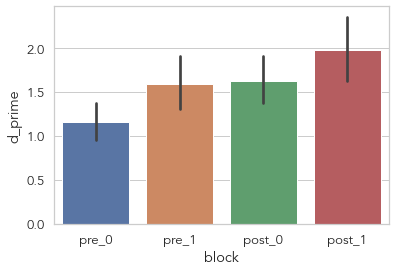

In [189]:
sns.barplot(data = d_blocks,
            y = 'd_prime',
            x = 'block',
            order=block_order)

In [190]:
d_phase = df_zip[~df_zip.flagRT].groupby(['gameID','phase']).apply(d_primes).reset_index()
d_phase = d_phase.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='phase', ylabel='d_prime'>

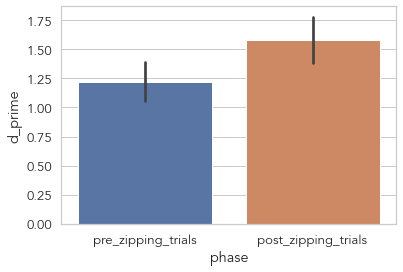

In [191]:
sns.barplot(data = d_phase,
            y = 'd_prime',
            x = 'phase',
            order = phase_order)

In [192]:
d_phase_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','phase','compatibility']).apply(d_primes).reset_index()
d_phase_compatibility = d_phase_compatibility.rename(columns = {0: 'd_prime'})

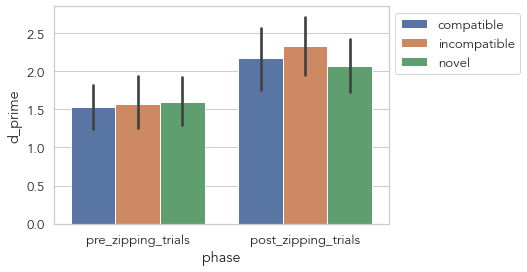

In [253]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            x = 'phase',
            hue = 'compatibility',
            order = phase_order)
plt.legend(bbox_to_anchor=(1,1))

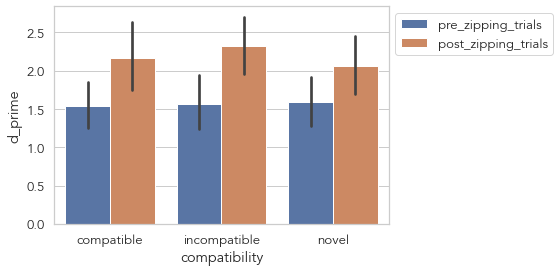

In [254]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            hue = 'phase',
            x = 'compatibility',
            hue_order = phase_order)
plt.legend(bbox_to_anchor=(1,1))

In [195]:
d_block_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','block','compatibility']).apply(d_primes).reset_index()
d_block_compatibility = d_block_compatibility.rename(columns = {0: 'd_prime'})

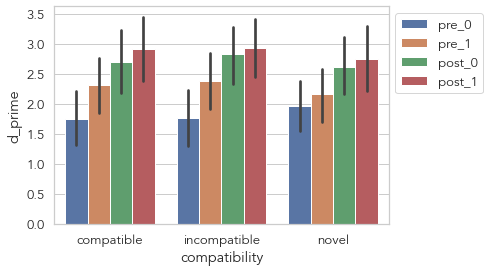

In [196]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            hue = 'block',
            x = 'compatibility',
            hue_order = block_order)
plt.legend(bbox_to_anchor=(1,1))

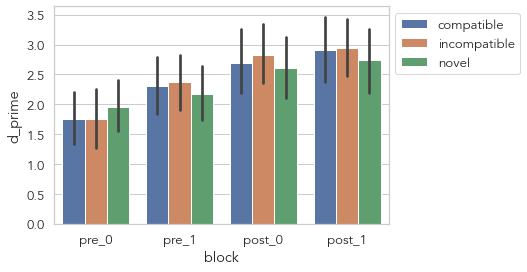

In [197]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            x = 'block',
            hue = 'compatibility',
            order = block_order)
plt.legend(bbox_to_anchor=(1,1))

## Building Trials

In [198]:
df_build['trial_duration'] = df_build.timeAbsolute - df_build.trial_start_time
df_build['trial_duration_min'] =  df_build['trial_duration'] / (60 * 1000)

### whole trials

In [199]:
ppts_left = list(df_zip.gameID.unique())

In [200]:
df_build = df_build[df_build.gameID.isin(ppts_left)]

In [201]:
df_ppt_info = df_zip[['gameID', 'rotation_name']].groupby('gameID').first()

In [202]:
df_build_means = df_build.groupby('gameID').mean().reset_index().merge(df_ppt_info, how='left', on='gameID')
df_build_phase_means = df_build.groupby(['gameID','rep']).mean().reset_index().merge(df_ppt_info, how='left', on='gameID')
df_build_part_means = df_build.groupby(['gameID','chunk_id']).mean().reset_index().merge(df_ppt_info, how='left', on='gameID')

In [203]:
df_build_phase_means

,gameID,rep,timeAbsolute,timeRelative,trial_start_time,relative_time,n_resets,trial_index,time_elapsed,trial_num,trial_duration,trial_duration_min,rotation_name
0,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,0,1.657218e+12,1156572.50,1.657218e+12,195071.50,7.75,86.5,1129222.75,1.5,195071.25,3.251187,r_2
1,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,1,1.657219e+12,1579738.00,1.657219e+12,21079.50,0.75,90.5,1552397.50,5.5,21079.50,0.351325,r_2
2,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,2,1.657219e+12,1641661.75,1.657219e+12,13070.75,0.25,94.5,1614451.25,9.5,13070.75,0.217846,r_2
3,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,3,1.657219e+12,1703448.75,1.657219e+12,11854.00,0.25,98.5,1676301.00,13.5,11854.00,0.197567,r_2
4,0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,0,1.657236e+12,822198.75,1.657236e+12,59285.75,1.50,86.5,822706.50,1.5,59285.75,0.988096,p_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,9919-0afd12f9-126c-4f2e-b2d0-c1c6ebb18a2b,3,1.657250e+12,1631420.00,1.657249e+12,15627.75,0.00,98.5,1631864.00,13.5,15627.50,0.260458,q_2
284,9984-ef648e44-23bb-4658-96f4-7be5c145c151,0,1.657226e+12,730488.50,1.657226e+12,48530.75,1.75,86.5,729811.75,1.5,48530.25,0.808837,p_2
285,9984-ef648e44-23bb-4658-96f4-7be5c145c151,1,1.657226e+12,814789.75,1.657226e+12,10078.00,0.00,90.5,814141.25,5.5,10077.50,0.167958,p_2
286,9984-ef648e44-23bb-4658-96f4-7be5c145c151,2,1.657226e+12,861135.25,1.657226e+12,7948.75,0.00,94.5,860533.75,9.5,7948.00,0.132467,p_2


### Resets

In [204]:
# what is the overall variation in build performance?

Text(0.5, 1.0, 'mean number of resets across trials')

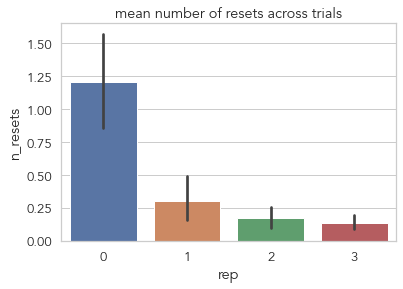

In [205]:
sns.barplot(data = df_build_phase_means,
            y = 'n_resets',
            x = 'rep')
plt.title('mean number of resets across trials')

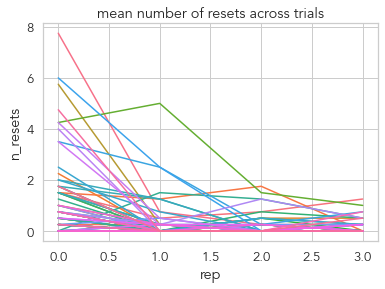

In [206]:
sns.lineplot(data = df_build_phase_means,
            y = 'n_resets',
            x = 'rep',
            hue= 'gameID')
plt.title('mean number of resets across trials')
plt.legend([],[], frameon=False)

Text(0.5, 1.0, 'mean number of resets in trial for each ppt')

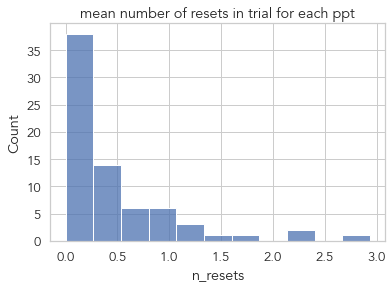

In [207]:
sns.histplot(df_build_means.n_resets)
plt.title('mean number of resets in trial for each ppt')

### Build time

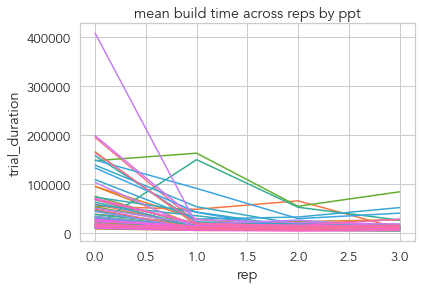

In [208]:
sns.lineplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rep',
            hue= 'gameID')
plt.title('mean build time across reps by ppt')
plt.legend([],[], frameon=False)

Text(0.5, 1.0, 'mean build time across reps')

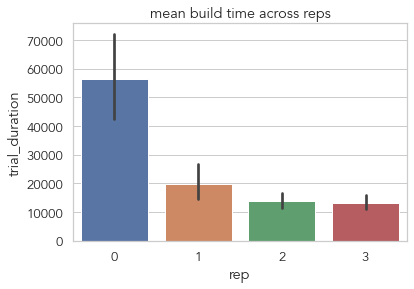

In [209]:
sns.barplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rep')

plt.title('mean build time across reps')

Text(0.5, 1.0, 'mean ppt build time')

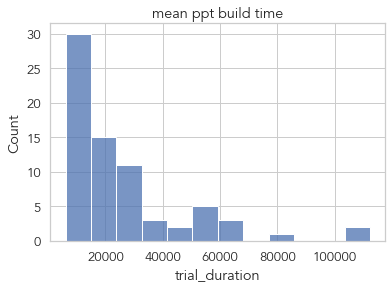

In [210]:
# what's the variation across people?

sns.histplot(data = df_build_means,
            x = 'trial_duration')

plt.title('mean ppt build time')

### What explains this variation?

#### Are some chunks harder than others?

In [211]:
three_composites = pd.read_csv('../../stimuli/block_utils/ambiguous/df_stims_pre_post_run_0.csv')

In [212]:
three_composites[['tower_id_tall','tower_A_tall_id','tower_B_tall_id','tower_A_wide_id','tower_B_wide_id']]

,tower_id_tall,tower_A_tall_id,tower_B_tall_id,tower_A_wide_id,tower_B_wide_id
0,talls_111_127,tall_111,tall_127,wide_011,wide_015
1,talls_102_122,tall_102,tall_122,wide_025,wide_010
2,talls_101_114,tall_101,tall_114,wide_019,wide_008


In [213]:
# ordered first by tall/ wide, then by composite in which they appear
part_order_tall_wide = \
              ['tall_111', 'tall_127',
              'tall_102', 'tall_122',
              'tall_101', 'tall_114',
              'wide_011', 'wide_015',
              'wide_025', 'wide_010',
              'wide_019', 'wide_008']

# ordered first by composite in which they appear, then by tall/ wide
part_order_composites = \
              ['tall_111', 'tall_127',
               'wide_011', 'wide_015',
               'tall_102', 'tall_122',
               'wide_025', 'wide_010',
               'tall_101', 'tall_114',
               'wide_019', 'wide_008']

part_order = part_order_composites

Text(0.5, 1.0, 'mean number of resets across parts')

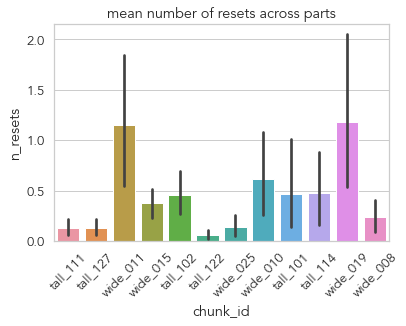

In [214]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_build_part_means,
            y = 'n_resets',
            x = 'chunk_id',
            order = part_order)
plt.xticks(rotation = 45)
plt.title('mean number of resets across parts')

Text(0.5, 1.0, 'mean build time across parts')

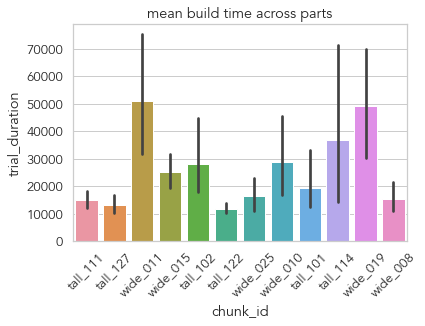

In [215]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_build_part_means,
            y = 'trial_duration',
            x = 'chunk_id',
            order = part_order)
plt.xticks(rotation = 45)
plt.title('mean build time across parts')

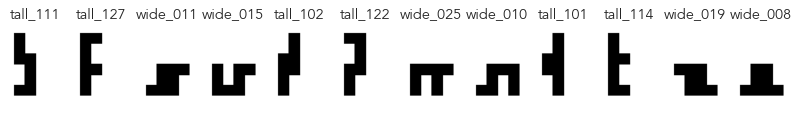

In [216]:
fig, axs = plt.subplots(1, 12, figsize=(14,5))

for i, part in enumerate(part_order):
    show_part_subplot(part, axs[i])

#### Rotation

Text(0.5, 1.0, 'mean build time across rotations')

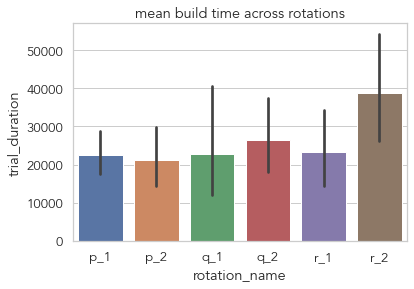

In [217]:
sns.barplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rotation_name',
            order=rotation_order)

plt.title('mean build time across rotations')

In [218]:
df_meta[['rotation_name','rotation']].iloc[3]['rotation']

{'build_wide': 'talls_111_127',
 'build_tall': 'talls_101_114',
 'novel': 'talls_102_122'}

### How does building performance relate to zipping performance?

Do the better builders have larger pre-post differences? (specifically for compatible trials?)
Do the worse builders have larger pre-post differences? (specifically for compatible trials?)
Do the most improving builders have larger pre-post differences? (specifically for compatible trials?)

In [219]:
df_build_means_condensed = df_build_means[['gameID', 'trial_duration', 'n_resets']].rename(columns = {'trial_duration':'build_duration'})

In [220]:
# need a dataframe with mean building performance and diffs.
df_build_zip_performance =  ppt_phase_compatibility_diffs.merge(df_build_means_condensed)

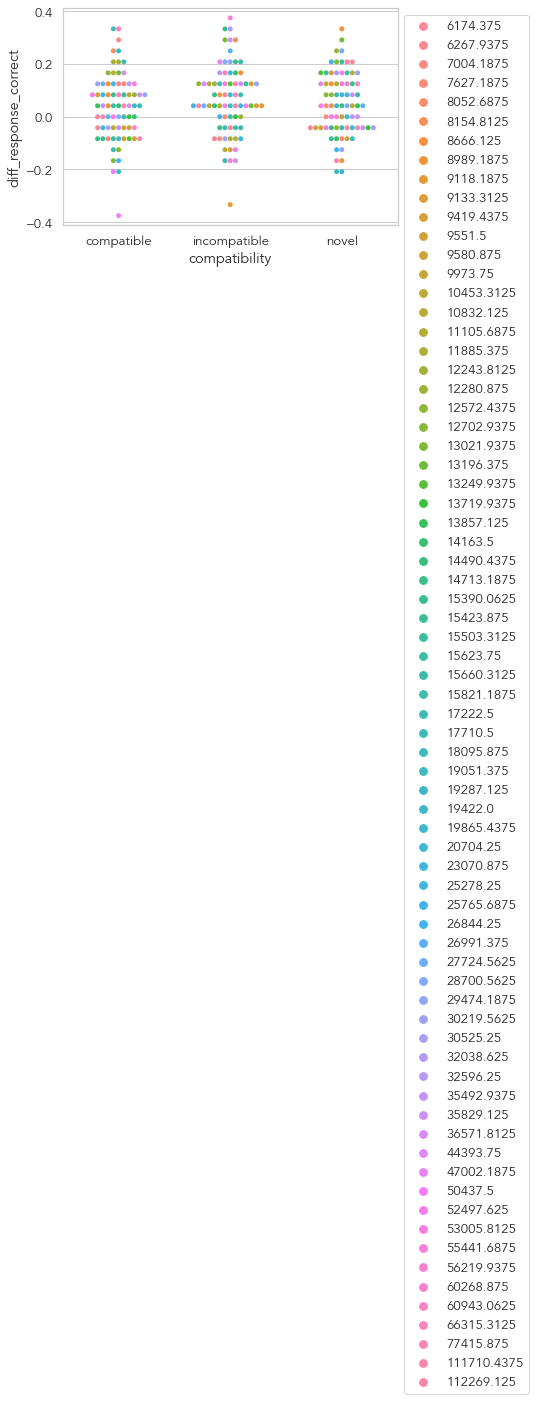

In [221]:
sns.swarmplot(data = df_build_zip_performance,
            hue = 'build_duration',
            y = 'diff_response_correct',
            x = 'compatibility')
# plt.legend([],[], frameon=False)
plt.legend(bbox_to_anchor=(1,1))


/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


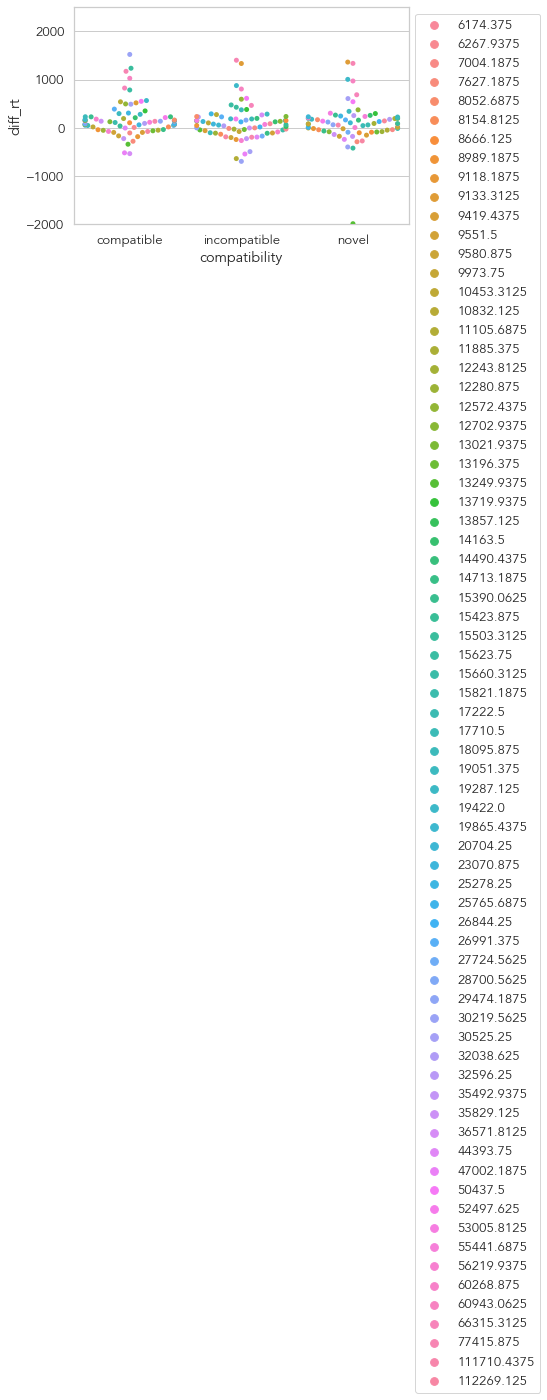

In [222]:
sns.swarmplot(data = df_build_zip_performance,
            hue = 'build_duration',
            y = 'diff_rt',
            x = 'compatibility')
# plt.legend([],[], frameon=False)
plt.ylim(-2000,2500)
plt.legend(bbox_to_anchor=(1,1))

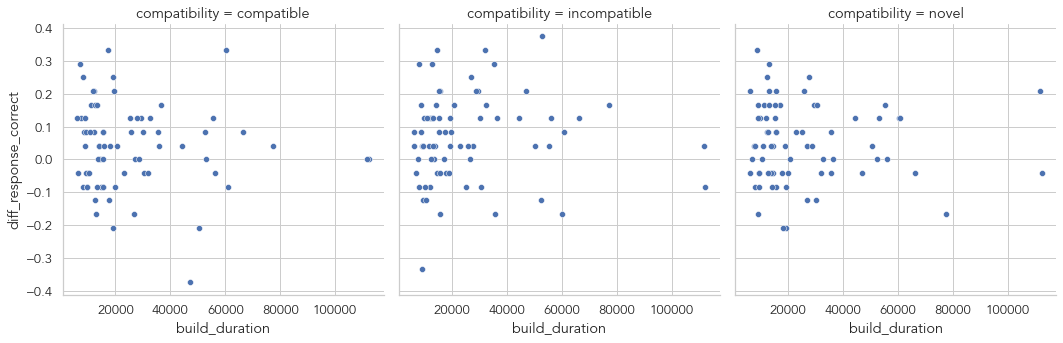

In [223]:
sns.relplot(data = df_build_zip_performance,
                col = 'compatibility',
                y = 'diff_response_correct',
                x = 'build_duration')

In [251]:
df_build_zip_performance

,gameID,compatibility,diff_response_correct,diff_rt,iterationName,rotation_name,mean_rt,mean_response_correct,build_duration,n_resets
0,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,compatible,0.333333,180.541667,pre_post_run_0,r_2,1185.875000,0.916667,60268.8750,2.2500
1,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,incompatible,-0.166667,-84.791667,pre_post_run_0,r_2,1185.875000,0.916667,60268.8750,2.2500
2,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,novel,0.125000,204.125000,pre_post_run_0,r_2,1185.875000,0.916667,60268.8750,2.2500
3,0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,compatible,0.125000,137.183333,pre_post_run_0,p_1,1056.308333,0.875000,29474.1875,1.0000
4,0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,incompatible,0.208333,-0.583333,pre_post_run_0,p_1,1056.308333,0.875000,29474.1875,1.0000
...,...,...,...,...,...,...,...,...,...,...
211,9919-0afd12f9-126c-4f2e-b2d0-c1c6ebb18a2b,incompatible,-0.125000,183.583333,pre_post_run_0,q_2,1012.745833,0.583333,52497.6250,1.1875
212,9919-0afd12f9-126c-4f2e-b2d0-c1c6ebb18a2b,novel,0.000000,139.050000,pre_post_run_0,q_2,1012.745833,0.583333,52497.6250,1.1875
213,9984-ef648e44-23bb-4658-96f4-7be5c145c151,compatible,-0.083333,173.345833,pre_post_run_0,p_2,979.200000,0.625000,19865.4375,0.5625
214,9984-ef648e44-23bb-4658-96f4-7be5c145c151,incompatible,0.083333,57.212500,pre_post_run_0,p_2,979.200000,0.625000,19865.4375,0.5625


### individual block placements

In [224]:
df_block_placements

,_id,experimentName,iterationName,workerID,gameID,studyLocation,timeAbsolute,timeRelative,blocks,discreteWorld,...,datatype,stimURL,stimulus,stimId,chunk_id,rep,condition,chunk_type,n_block,n_resets
0,62c720dcedff9c1246774da4,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,587471,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}]","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,1,0
1,62c720e3edff9c1246774da7,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,594263,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,2,0
2,62c720e5edff9c1246774da9,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,596966,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,3,0
3,62c720e6edff9c1246774dab,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,598087,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,4,0
4,62c720ededff9c1246774db0,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,604838,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}]","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",011,wide_011,0,building,wide,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8376,62c85ee3edff9c124677b5ed,block_construction_zipping,pre_post_run_0,62b0d24d95bc72be2f45c720,8279-b42299da-b11d-46f2-b745-61fb50dc9082,Prolific,1.657299e+12,798908,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",102,tall_102,3,building,tall,4,0
8377,62c85ee7edff9c124677b5f0,block_construction_zipping,pre_post_run_0,62b0d24d95bc72be2f45c720,8279-b42299da-b11d-46f2-b745-61fb50dc9082,Prolific,1.657299e+12,802614,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}]","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...",019,wide_019,3,building,wide,1,0
8378,62c85eededff9c124677b5f1,block_construction_zipping,pre_post_run_0,62b0d24d95bc72be2f45c720,8279-b42299da-b11d-46f2-b745-61fb50dc9082,Prolific,1.657299e+12,808562,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...",019,wide_019,3,building,wide,2,0
8379,62c85eeeedff9c124677b5f2,block_construction_zipping,pre_post_run_0,62b0d24d95bc72be2f45c720,8279-b42299da-b11d-46f2-b745-61fb50dc9082,Prolific,1.657299e+12,809887,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silho

### resets

In [225]:
df_resets.columns

Index(['_id', 'experimentName', 'iterationName', 'workerID', 'gameID',
       'studyLocation', 'n_blocks_when_reset', 'trial_start_time',
       'relative_time', 'datatype', 'stimURL', 'stimulus', 'stimId',
       'chunk_id', 'rep', 'condition', 'chunk_type', 'n_block', 'n_resets'],
      dtype='object')

In [226]:
import blockworld_utils as utils

In [227]:
# [utils.draw_world(utils.worldify(w)) for w in df_block_placements.blocks]

In [63]:
df_survey

,_id,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,experimentName,iterationName,workerID,gameID,studyLocation,datatype,response_key_dict
0,62c7231dedff9c124677507b,24152.6,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,176,1163160,0.0-176.0,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
1,62c7237dedff9c12467750b9,12181.4,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,176,1237230,0.0-176.0,block_construction_zipping,pre_post_run_0,60a0067f943f8d336ec80fa1,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
2,62c723a4edff9c12467750d7,4539.6,"{'technical': '', 'confused': '', 'comments': ''}",survey-text,176,1221847,0.0-176.0,block_construction_zipping,pre_post_run_0,60dd22f2f6aa769f57e2c55b,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
3,62c725d4edff9c12467751de,27195.9,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,176,1723486,0.0-176.0,block_construction_zipping,pre_post_run_0,5e5580651ffa37588a3697c1,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
4,62c72914edff9c1246775293,17166.0,"{'technical': 'o', 'confused': 'no', 'comments...",survey-text,176,2289173,0.0-176.0,block_construction_zipping,pre_post_run_0,5bcdb2880ba8a4000125ed43,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
5,62c743baedff9c1246776052,28329.8,"{'technical': '', 'confused': '', 'comments': ''}",survey-text,176,1282965,0.0-176.0,block_construction_zipping,pre_post_run_0,6102bbdba4dd279363094fca,1302-913536d2-7068-4cc3-b278-aa4be9edc302,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
6,62c743bfedff9c1246776064,13076.2,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,176,1293785,0.0-176.0,block_construction_zipping,pre_post_run_0,603bb3cfd1aca681ef60b8cd,1739-4e73d91f-c931-4343-bc0c-0cfaeef51060,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
7,62c743f9edff9c1246776129,11426.3,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,176,1363891,0.0-176.0,block_construction_zipping,pre_post_run_0,5d5a3cc29fe0f0001b0f44a4,3355-95b2fcf7-1cb9-4424-b7bc-57c6b15302fc,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
8,62c74454edff9c124677623c,30378.2,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,176,1799297,0.0-176.0,block_construction_zipping,pre_post_run_0,5c5d36bc034e280001644c3b,8700-7d224bf4-f965-4b22-8729-3ebebe3282d3,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
9,62c744a1edff9c12467762f6,34629.4,"{'technical': 'no', 'confused': 'In part two, ...",survey-text,176,1416238,0.0-176.0,block_construction_zipping,pre_post_run_0,5ed403a89542210ab77530b7,9984-ef648e44-23bb-4658-96f4-7be5c145c151,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"


In [64]:
df_zip.to_csv('../results/zipping/csv/pilot_0_zipping_trials.csv')

In [65]:
!! open .

[]